In [ ]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc
import pickle
from wordcloud import WordCloud

In [ ]:
# Function to load data
def load_data(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    return pd.DataFrame(data)

In [ ]:
# Load and preprocess data
df = load_data('/content/drive/MyDrive/combinedData.json')

In [ ]:
# Basic statistical summary
print("Summary Statistics:\n", df.describe())
print("\nMissing Values:\n", df.isnull().sum())

Summary Statistics:
             overall  unixReviewTime         class
count  3.185845e+06    3.185845e+06  3.185845e+06
mean   3.893530e+00    1.364454e+09  7.078141e-01
std    1.432947e+00    4.114643e+07  4.547674e-01
min    1.000000e+00    9.427968e+08  0.000000e+00
25%    3.000000e+00    1.355098e+09  0.000000e+00
50%    5.000000e+00    1.374365e+09  1.000000e+00
75%    5.000000e+00    1.391386e+09  1.000000e+00
max    5.000000e+00    1.406074e+09  1.000000e+00

Missing Values:
 _id                   0
reviewerID            0
asin                  0
reviewerName      35568
helpful               0
reviewText            0
overall               0
summary               0
unixReviewTime        0
reviewTime            0
category              0
class                 0
dtype: int64


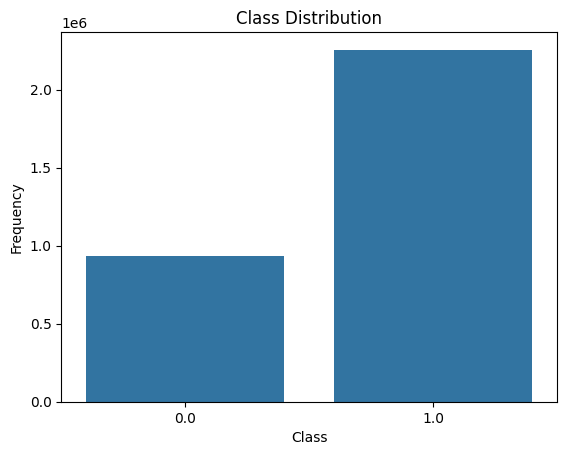

In [ ]:
# Class Distribution
sns.countplot(x='class', data=df)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

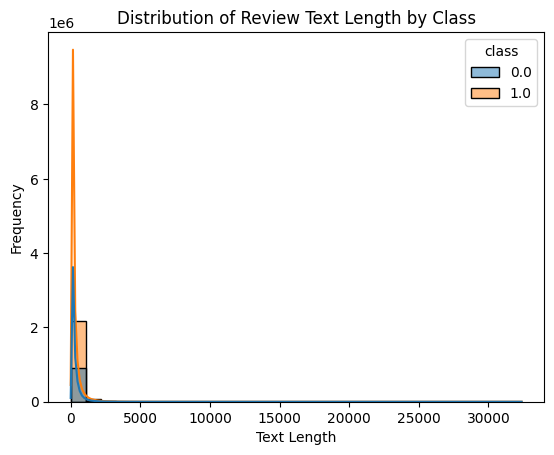

In [ ]:
# Text Length Analysis
df['text_length'] = df['reviewText'].apply(len)
sns.histplot(data=df, x='text_length', hue='class', bins=30, kde=True)
plt.title('Distribution of Review Text Length by Class')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

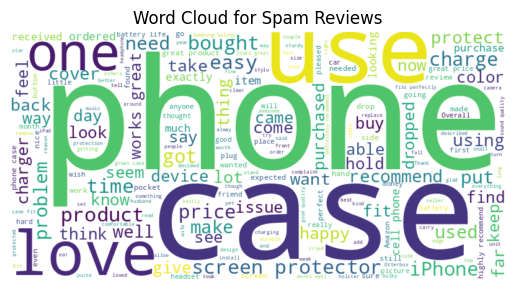

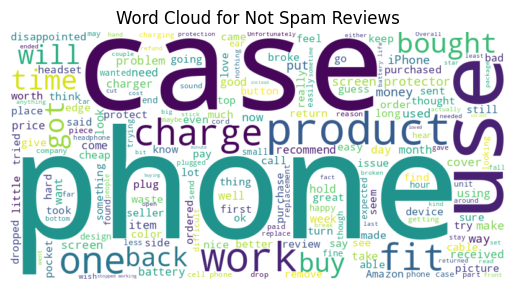

In [ ]:
# Word Cloud for Spam and Not Spam
spam_text = " ".join(df[df['class'] == 1]['reviewText'])
not_spam_text = " ".join(df[df['class'] == 0]['reviewText'])

spam_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(spam_text)
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Spam Reviews')
plt.show()

not_spam_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(not_spam_text)
plt.imshow(not_spam_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Not Spam Reviews')
plt.show()

In [ ]:
# Split data into training and validation sets
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['reviewText'].tolist(),
    df['class'].tolist(),
    test_size=0.2,
    random_state=42
)

In [ ]:
# Vectorization
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train_texts)
X_val = vectorizer.transform(val_texts)

# Train LogisticRegression Model
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, train_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

In [ ]:
# Save the LogisticRegression model and vectorizer
with open('logistic_regression_logistic_spam_detector.pkl', 'wb') as model_file:
    pickle.dump(logistic_model, model_file)

with open('logistic_regression_count_vectorizer.pkl', 'wb') as vec_file:
    pickle.dump(vectorizer, vec_file)

In [ ]:
# Function for LogisticRegression prediction
def predict_spam_nb(review, model, vectorizer):
    review_vectorized = vectorizer.transform([review])
    prediction = model.predict(review_vectorized)
    return "Spam" if prediction[0] == 1 else "Not Spam"

In [ ]:
result = predict_spam_nb("It is very good", logistic_model, vectorizer)
print(result)

Spam


In [ ]:
# Model Evaluation
val_preds = logistic_model.predict(X_val)

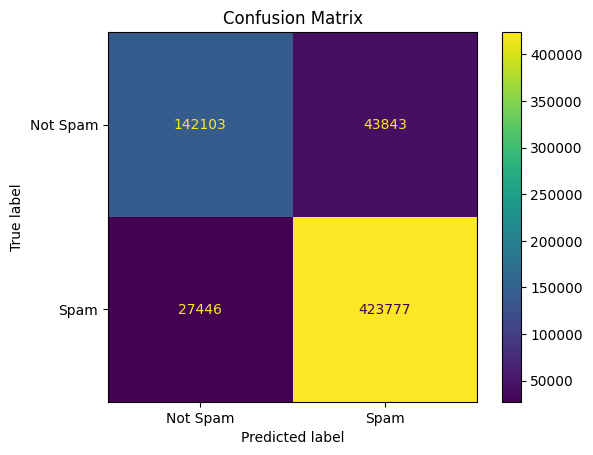

Classification Report:
               precision    recall  f1-score   support

    Not Spam       0.84      0.76      0.80    185946
        Spam       0.91      0.94      0.92    451223

    accuracy                           0.89    637169
   macro avg       0.87      0.85      0.86    637169
weighted avg       0.89      0.89      0.89    637169



In [ ]:
# Confusion Matrix
cm = confusion_matrix(val_labels, val_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Spam', 'Spam'])
disp.plot()
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:\n", classification_report(val_labels, val_preds, target_names=['Not Spam', 'Spam']))


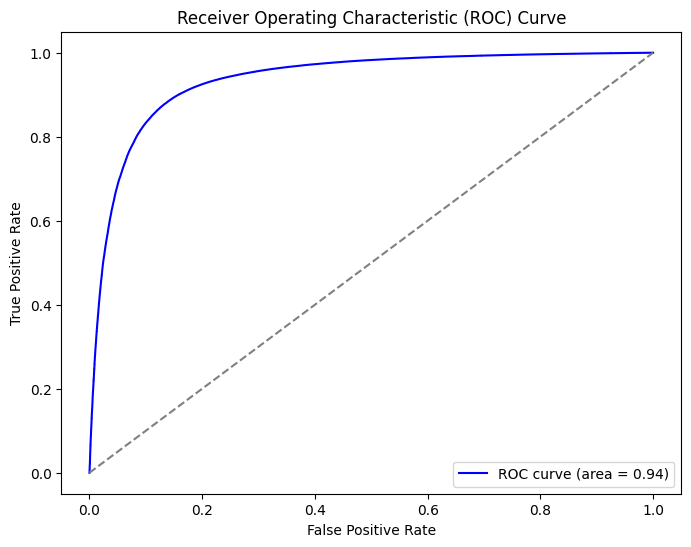

In [ ]:
# ROC Curve
val_probs = logistic_model.predict_proba(X_val)[:, 1]
fpr, tpr, _ = roc_curve(val_labels, val_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

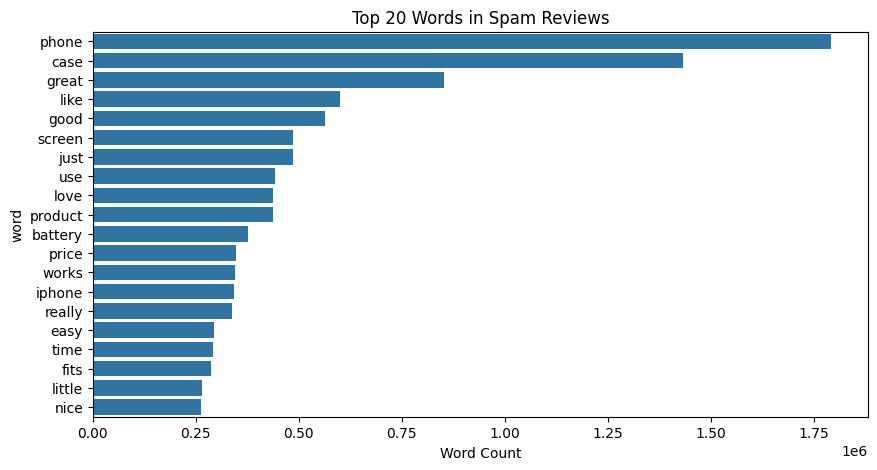

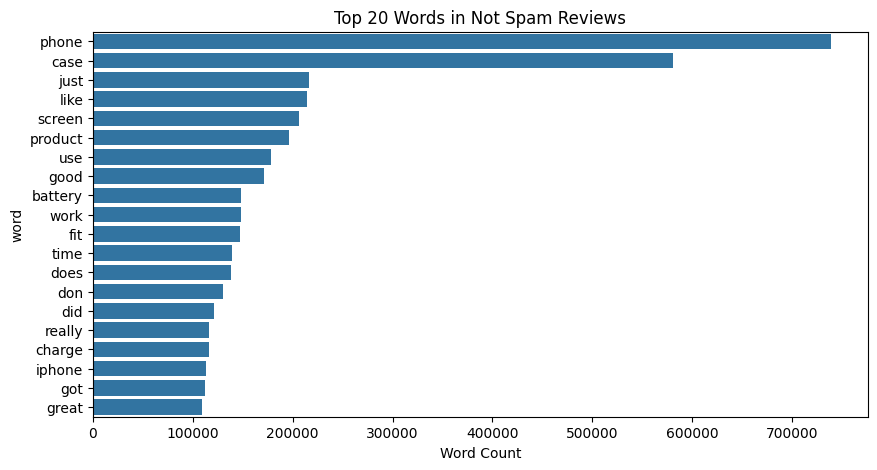

In [ ]:

# Top Words Analysis
# Fit CountVectorizer on spam and non-spam texts separately
vectorizer_spam = CountVectorizer(stop_words='english', max_features=20)
vectorizer_not_spam = CountVectorizer(stop_words='english', max_features=20)

spam_words = vectorizer_spam.fit_transform(df[df['class'] == 1]['reviewText']).toarray().sum(axis=0)
not_spam_words = vectorizer_not_spam.fit_transform(df[df['class'] == 0]['reviewText']).toarray().sum(axis=0)

spam_word_counts = pd.DataFrame({'word': vectorizer_spam.get_feature_names_out(), 'count': spam_words})
not_spam_word_counts = pd.DataFrame({'word': vectorizer_not_spam.get_feature_names_out(), 'count': not_spam_words})

plt.figure(figsize=(10, 5))
sns.barplot(x='count', y='word', data=spam_word_counts.sort_values(by='count', ascending=False))
plt.title('Top 20 Words in Spam Reviews')
plt.xlabel('Word Count')
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(x='count', y='word', data=not_spam_word_counts.sort_values(by='count', ascending=False))
plt.title('Top 20 Words in Not Spam Reviews')
plt.xlabel('Word Count')
plt.show()